# Part 2: Bounding Box Regressor
Train a CNN to locate the 4 coordinates for each character in a given image

In [1]:
from os import listdir
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS = len(SYMBOL_SET)

In [3]:
# Helper function for One-hot encoding a symbol
def onehot(x):
    b = np.zeros(NUM_SYMBOLS)
    b[x] = 1
    return b

In [4]:
def generate_captcha(return_image=False):
    fonts = [i for i in listdir("../fonts") if i.endswith('.ttf')]
    while True:
        x_pos = 0
        boxes = []
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(NUMCHARS):
            font = ImageFont.truetype(f'../fonts/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            character = SYMBOL_SET[randrange(NUM_SYMBOLS)]
            x_pos += randrange(10, MINX)
            y_pos = randrange(MINY, MAXY)
            position = (x_pos, y_pos)
            coords = canvas.textbbox(position, character, font)
            canvas.text(position, character, font=font, fill=(0,0,0), anchor="la")
            boxes.append(coords)
            x_pos = coords[2]
        x = np.array(list(img.tobytes())).reshape(WIDTH, HEIGHT, 3).astype(np.float64)/255.0
        
        if return_image:
            yield x, np.array(boxes).flatten(), img
        else:
            yield x, np.array(boxes).flatten()

In [5]:
def draw_boxes(image, truth, pred=None):
    canvas = ImageDraw.Draw(image)
    truth = np.reshape(truth, (4,4))
    if pred is not None:
        pred = np.reshape(pred, (4,4))
    for i in range(len(truth)):
        canvas.rectangle(list(truth[i]), outline=(0, 255, 0), width=1)
        if pred is not None:
            canvas.rectangle(list(pred[i]), outline=(255 ,0 ,0), width=1)
    display(image)

Bounding Boxes: [ 15  42  41  76  59  24  78  50  96  44 105  61 115  35 136  64] (16,)


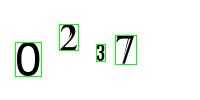

In [6]:
(x, y, image) = next(generate_captcha(return_image=True))
print("Bounding Boxes:", y, y.shape)
draw_boxes(image, y)

In [7]:
box_dataset = tf.data.Dataset.from_generator(generate_captcha,
            output_signature=(tf.TensorSpec(shape=(WIDTH, HEIGHT, 3), dtype=tf.float64),
                             tf.TensorSpec(shape=(4*NUMCHARS,), dtype=tf.float32)
                             ))
box_dataset = box_dataset.batch(batch_size=32)

In [8]:
PATH = './logs/box_regressor/'
log_dir = PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

box_model = models.Sequential()
box_model.add(layers.Input(shape=(WIDTH, HEIGHT, 3)))
box_model.add(layers.Conv2D(8,(3,3),activation='relu'))
box_model.add(layers.MaxPooling2D(pool_size=(2,2)))
box_model.add(layers.Conv2D(32,(3,3),activation='relu'))
box_model.add(layers.MaxPooling2D(pool_size=(2,2)))
box_model.add(layers.Conv2D(64,(3,3),activation='relu'))
box_model.add(layers.MaxPooling2D(pool_size=(2,2)))
box_model.add(layers.Flatten())
box_model.add(layers.Dense(128, activation='relu'))
box_model.add(layers.Dropout(0.25))
box_model.add(layers.Dense(64, activation='relu'))
box_model.add(layers.Dropout(0.25))
box_model.add(layers.Dense(4*NUMCHARS, activation='relu'))

box_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
box_history = box_model.fit(box_dataset, epochs=100, steps_per_epoch=500, callbacks=[tensorboard_callback])
box_model.save("../models/BBox_Regressor-100epochs.keras")
# box_model = models.load_model("../models/BBox_Regressor-100epochs.keras")
box_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 98, 8)          │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 49, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 47, 32)          │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,884,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,743,922 (21.91 MB)

 Trainable params: 1,914,640 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,829,282 (14.61 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Truth: [ 11  40  33  71  47  28  55  44  70  38  83  58  94  37 117  66]
Predicted: [ 13.779058  42.24375   29.88258   66.75161   43.04905   28.182205
  55.351753  47.66092   68.429085  36.805397  83.517395  59.919373
  96.662346  39.95809  114.78133   64.63495 ]


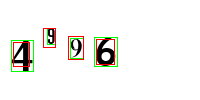

In [9]:
(x, y, image) = next(generate_captcha(return_image=True))
y_pred = box_model.predict(x.reshape(-1, WIDTH, HEIGHT, 3))[0]
print("Truth:", y)
print("Predicted:", y_pred)
draw_boxes(image, y, y_pred)

In [10]:
# Evaluate the Bounding Box Regressor
error_margin = 5
test_size = 1000
count = 0

for i in range(test_size):
    (x, y, image) = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(-1, WIDTH, HEIGHT, 3), verbose=False)[0]
    for i in range(4):
        if abs(y[i]-y_pred[i]) > error_margin:
            count += 1
print("Accuracy of", (test_size-count/4)*100/test_size, "% with error margin of", error_margin, "pixels")

Accuracy of 90.325 % with error margin of 5 pixels
